In [8]:
import configparser
import requests
import json
import prettytable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Optional, Tuple

sns.set_theme(style="whitegrid")
plt.rcParams['lines.linewidth'] = 3

proc_dir = Path('../proc_data/')
out_dir = Path('../tables_and_figures/')
data_dir = Path('../raw_data/')


# Load API key from config.ini
# Copy config.ini.example -> config.ini and fill in your key
_config = configparser.ConfigParser()
_config.read(Path('../config.ini'))
api_key = _config['api_keys']['bls_api_key']
headers = {'Content-type': 'application/json'}

ppi_dict = {'WPUFD4':'PPI Final Demand',
 'WPUFD41':'PPI Final Demand Goods',
 'WPUFD42':'PPI Final Demand Services',
 'WPUFD49104':'PPI Final Demand Less Food and Energy',
 'WPUID61':'PPI Processed goods for intermediate demand',
 'WPUID62':'PPI Unprocessed goods for intermediate demand',
 'WPU00000000':'PPI All Commodities',
 'CUUR0000SA0': 'CPI-U All Urban Consumers',
 'CUUR0000SA0L1E':'CPI-U All Urban Consumers Less Energy',
 'CUUS0000SA0L12E':'CPI-U All Urban Consumers Less Food, Shelter, Energy',
 'PCU311311': 'Producer Price Index by Industry: Food Manufacturing',
 'WPU57':'PPI Wholesale Trade Services',
 'WPU58':'PPI Retail Trade Services',
 'WPSFD423': 'PPI Final Demand Trade Services',
 'WPUFD411': 'PPI Final Demand Foods',
 'WPU5811': 'PPI Food and Alcohol Retailing',
'PCU445110445110': 'PPI Supermarkets and Other Grocery Stores',
'price_ret_I_all_est': 'Alvarez-Blaser et. al (2025) Prices',
'markup_tot_all_est': 'Alvarez-Blaser et. al (2025) Total Markup',
 }


def clean_ppi(fn='ppi.csv', df_markups=None) -> pd.DataFrame:
    df = pd.read_table(fn, sep=',')
    if df_markups is not None:
        df = pd.concat([df,df_markups],ignore_index=True)
    df['month']=df.period.str.replace('M','').astype(int)
    df['day'] = 1
    df['date']=pd.to_datetime(df[['year','month','day']])
    df['series_name']=df['series_id'].map(ppi_dict)
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    df.sort_values(['series_id', 'date'], inplace=True)
    df['pct_change'] = (
        df
        .groupby('series_id')['value']
        .transform(lambda s: 100 * s.pct_change(12))
    )
    return df

def select_series_date(
    df,
    my_date=pd.to_datetime('2019-01-01'),
    series_list=None,
    col='value_adjusted',
    ppi_dict=None,
    columns='code'   # 'code' returns columns as series_id, 'name' returns human-readable labels
):
    """
    Return pivoted DataFrame ready for plotting.

    Parameters
    ----------
    df : DataFrame
        Must contain columns: ['series_id','date','value'] (and optionally 'series_name').
    my_date : Timestamp
        Date used as base (denominator) for value_adjusted scaling.
    series_list : list or None
        If provided, only include these series codes.
    col : str
        Which column to return ('value_adjusted' or 'pct_change' etc). Function will compute value_adjusted.
    ppi_dict : dict or None
        Mapping series_id -> human-readable label (used only if columns == 'name').
    columns : str
        'code' to keep columns as series_id (recommended for color mapping).
        'name' to return human-readable column names (requires ppi_dict).
    Returns
    -------
    pivot_df : DataFrame
        index: date, columns: series codes (or names), values: requested col.
    """
    # ensure date is datetime
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # optionally filter series_list early
    if series_list is not None:
        df = df[df['series_id'].isin(series_list)]

    # Build base scaling table for my_date: use left join-style merge to keep all series
    base = df.loc[df['date'] == pd.to_datetime(my_date), ['series_id', 'value']].rename(columns={'value': 'value_scale'})

    # If some series missing on my_date, warn and drop those from the output
    missing = set(series_list or df['series_id'].unique()) - set(base['series_id'].unique())
    if missing:
        print("Warning: no base value for these series at my_date (they will be excluded):", missing)

    # Merge base scale onto full df
    df2 = df.merge(base, on='series_id', how='inner')  # inner ensures only series with a base value remain

    # Compute adjusted value
    df2['value_adjusted'] = 100.0 * df2['value'] / df2['value_scale']

    # Optionally select only dates >= my_date (as you did before)
    df2 = df2[df2['date'] >= pd.to_datetime(my_date)].copy()

    # Decide which column to pivot on
    if col not in df2.columns:
        raise ValueError(f"Column '{col}' not found in data. Available cols: {list(df2.columns)}")

    # Pivot: default to series_id as column keys (recommended)
    if columns == 'code':
        pivot = df2.pivot(index='date', columns='series_id', values=col)
    elif columns == 'name':
        if ppi_dict is None:
            raise ValueError("ppi_dict required when columns='name'")
        # create series_name column if not present
        df2['series_name'] = df2['series_id'].map(ppi_dict).fillna(df2['series_id'])
        pivot = df2.pivot(index='date', columns='series_name', values=col)
    else:
        raise ValueError("columns parameter must be 'code' or 'name'")

    # Sort columns in the original series_list order if provided
    if series_list is not None:
        existing = [s for s in series_list if s in pivot.columns]
        pivot = pivot[existing]

    return pivot

def plot_ppi_series(
    df,
    series,
    ppi_dict,
    start_date,
    select_series_date,
    value_col="value_adjusted",
    pct_col="pct_change",
    series_colors=None,
    figsize=(14, 6),
    save_path=out_dir / "ppi_trade_services.pdf",
    dpi=150,
    percent_xmax=100.0,
    legend_labels="both", 
    show=True
):
    ordered_series = list(series)

    # Colors
    tab10 = plt.get_cmap("tab10").colors
    if series_colors is None:
        series_colors = {s: tab10[i % len(tab10)] for i, s in enumerate(ordered_series)}

    # Pull data with columns as SERIES CODES
    levels_df = select_series_date(
        df,
        my_date=start_date,
        series_list=ordered_series,
        col=value_col,
        ppi_dict=ppi_dict,
        columns="code"
    )

    yoy_df = select_series_date(
        df,
        my_date=start_date,
        series_list=ordered_series,
        col=pct_col,
        ppi_dict=ppi_dict,
        columns="code"
    )

    # Keep only existing series
    existing = [s for s in ordered_series if s in levels_df.columns]

    # Build legend labels
    if legend_labels == "code":
        label_map = {s: s for s in existing}
    elif legend_labels == "name":
        label_map = {s: ppi_dict.get(s, s) for s in existing}
    elif legend_labels == "both":
        label_map = {s: f"{s} — {ppi_dict.get(s, s)}" for s in existing}
    else:
        raise ValueError("legend_labels must be 'code', 'name', or 'both'")

    # Rename AFTER color alignment
    levels_plot = levels_df[existing].rename(columns=label_map)
    yoy_plot = yoy_df[existing].rename(columns=label_map)

    colors = [series_colors[s] for s in existing]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    levels_plot.plot(ax=axes[0], color=colors)
    axes[0].set_title("PPI: Levels")
    axes[0].set_ylabel("Price Index (Jan 2019 = 100)")
    axes[0].set_xlabel("") 
    axes[0].legend(loc="upper left")

    yoy_plot.plot(ax=axes[1], color=colors, legend=False)
    axes[1].axhline(0, color="black", lw=1)
    axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=percent_xmax))
    axes[1].set_title("PPI: Inflation")
    axes[1].set_xlabel("")  # ← remove "date"
    axes[1].set_ylabel("Year-over-Year Change")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)

    if show:
        plt.show()

    return fig, axes, levels_df, yoy_df


In [9]:
data = json.dumps({"seriesid": list(ppi_dict.keys()),"startyear":"2011", "endyear":"2025","registrationkey":api_key})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data', data=data, headers=headers)
json_data = json.loads(p.text)

x=prettytable.PrettyTable(["series_id","year","period","value","footnotes"])
for series in json_data['Results']['series']:
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        value = item['value']
        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            x.add_row([seriesId,year,period,value,footnotes[0:-1]])


tbl_as_csv = x.get_csv_string().replace('\r','')
text_file = open(proc_dir / "ppi.csv", "w")
n = text_file.write(tbl_as_csv)
text_file.close()


In [10]:
df_markups = pd.read_csv(data_dir / 'markup_price_index.csv')
df_markups['year'] = df_markups['date'].apply(lambda x: int(x[0:4]))
df_markups['period'] = df_markups['date'].apply(lambda x: x[4:].upper())

df_markups_long = pd.melt(
    df_markups,
    id_vars=['year', 'period'],
    value_vars=['markup_tot_all_est', 'price_ret_I_all_est'],
    var_name='series_id',
    value_name='value'
)

df=clean_ppi(proc_dir / 'ppi.csv',df_markups_long)
df

,series_id,year,period,value,footnotes,month,day,date,series_name,pct_change
1439,CUUR0000SA0,2011,M01,220.223000,NaN,1,1,2011-01-01,CPI-U All Urban Consumers,NaN
1438,CUUR0000SA0,2011,M02,221.309000,NaN,2,1,2011-02-01,CPI-U All Urban Consumers,NaN
1437,CUUR0000SA0,2011,M03,223.467000,NaN,3,1,2011-03-01,CPI-U All Urban Consumers,NaN
1436,CUUR0000SA0,2011,M04,224.906000,NaN,4,1,2011-04-01,CPI-U All Urban Consumers,NaN
1435,CUUR0000SA0,2011,M05,225.964000,NaN,5,1,2011-05-01,CPI-U All Urban Consumers,NaN
...,...,...,...,...,...,...,...,...,...,...
2815,price_ret_I_all_est,2023,M2,1.105114,NaN,2,1,2023-02-01,Alvarez-Blaser et. al (2025) Prices,9.466385
2816,price_ret_I_all_est,2023,M3,1.097481,NaN,3,1,2023-03-01,Alvarez-Blaser et. al (2025) Prices,4.826218
2817,price_ret_I_all_est,2023,M4,1.108181,NaN,4,1,2023-04-01,Alvarez-Blaser et. al (2025) Prices,4.860876
2818,price_ret_I_all_est,2023,M5,1.114565,NaN,5,1,2023-05-01,Alvarez-Blaser et. al (2025) Prices,4.896063


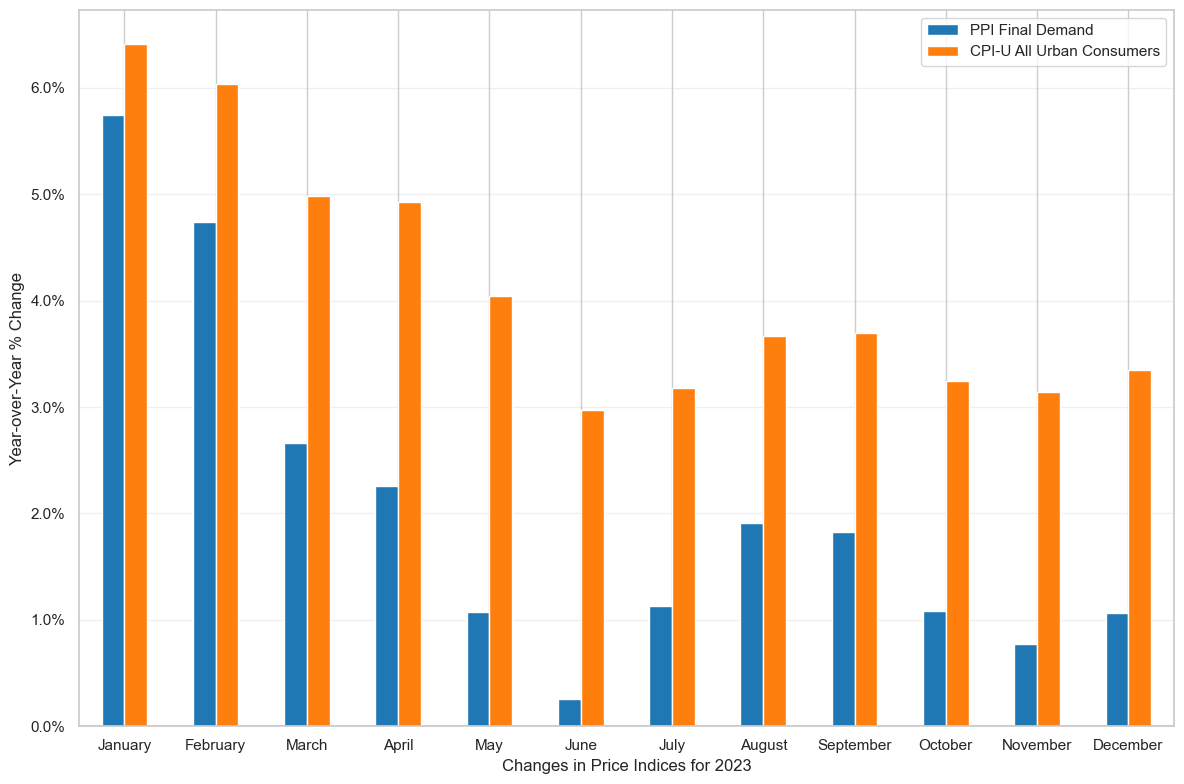

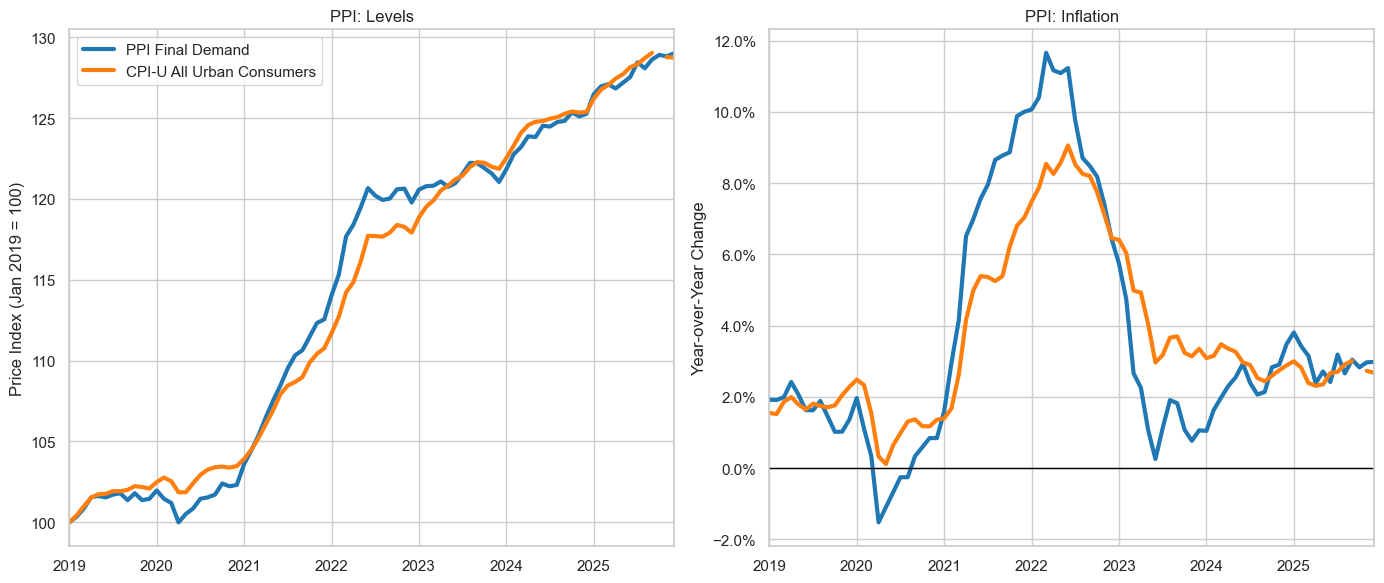

In [11]:
cpi_ppi_series = ['WPUFD4', 'CUUR0000SA0']

end_date = pd.to_datetime('2023-12-31')

tab10 = plt.get_cmap('tab10').colors
series_colors = {'WPUFD4': tab10[0], 'CUUR0000SA0': tab10[1]}

out_df = select_series_date(
    df,
    my_date=pd.to_datetime('2023-01-01'),
    series_list=cpi_ppi_series,
    col='pct_change',
    columns='code'
).query('date <= @end_date')

# Convert index to month names
out_df.index = out_df.index.month_name()

# Ensure correct column order
out_df = out_df[cpi_ppi_series]

# Explicit color list (order matters!)
color_list = [series_colors[s] for s in cpi_ppi_series]

ax = out_df.plot.bar(
    figsize=(12, 8),
    color=color_list,
    rot=0
)

# Legend labels (consistent with earlier figures)
legend_labels = [
    'PPI Final Demand',
    'CPI-U All Urban Consumers'
]

ax.legend(legend_labels)
ax.set_xlabel('Changes in Price Indices for 2023')
ax.set_ylabel('Year-over-Year % Change')

ax.axhline(0, color='black', lw=1)
ax.grid(axis='y', alpha=0.3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

plt.tight_layout()
plt.savefig(out_dir / 'ppi_groundwork.pdf', bbox_inches='tight')
plt.show()

fig, axes, levels_df, yoy_df = plot_ppi_series(
    df=df,
    series = cpi_ppi_series,
    ppi_dict=ppi_dict,
    start_date=pd.to_datetime('2019-01-01'),
    select_series_date=select_series_date,
    legend_labels="name",   # shows: code — name
    percent_xmax=100,        # because pct_change is already in percent
    save_path=out_dir / 'cpi_vs_ppi.pdf'
)


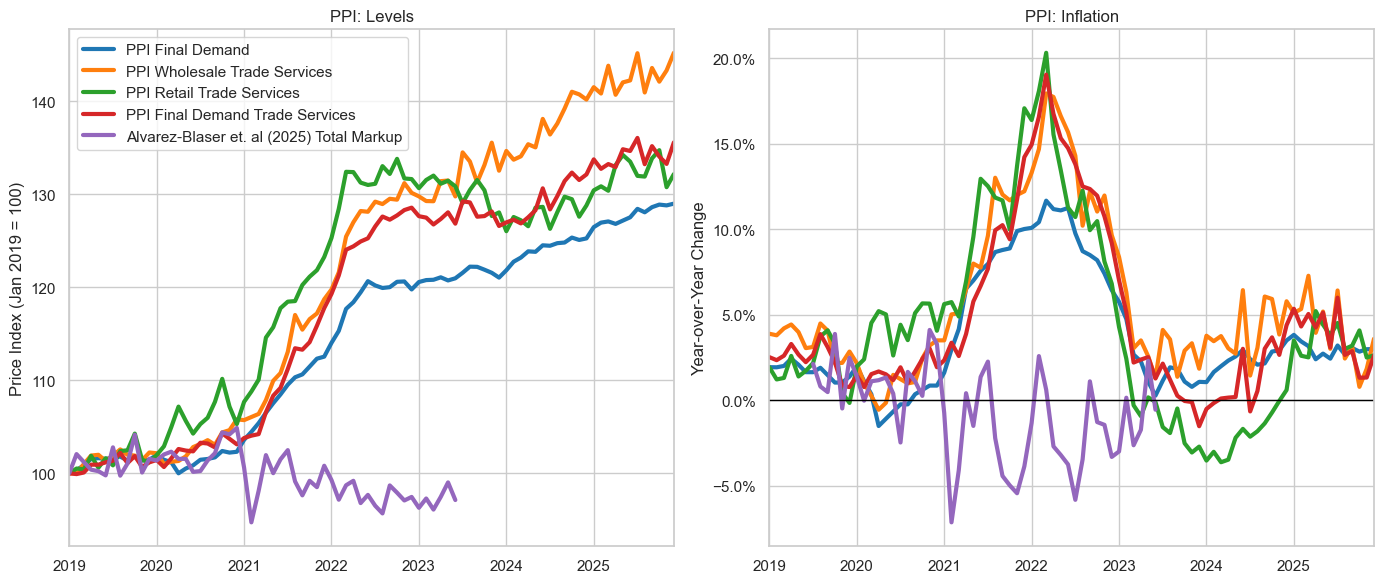

In [12]:
tab10 = plt.get_cmap('tab10').colors
series_colors = {
    'WPUFD4': tab10[0],
    'WPU57': tab10[1],
    'WPU58': tab10[2],
    'WPSFD423': tab10[3],
    'markup_tot_all_est': 'purple',
}

fig, axes, levels_df, yoy_df= plot_ppi_series(
    df=df,
    series=['WPUFD4','WPU57','WPU58','WPSFD423','markup_tot_all_est'],
    ppi_dict=ppi_dict,
    start_date=pd.to_datetime('2019-01-01'),
    select_series_date=select_series_date,
    legend_labels="name",   # 👈 shows codes + names
    percent_xmax=100,
    series_colors=series_colors,
    save_path=out_dir / 'ppi_trade_services.pdf',
)

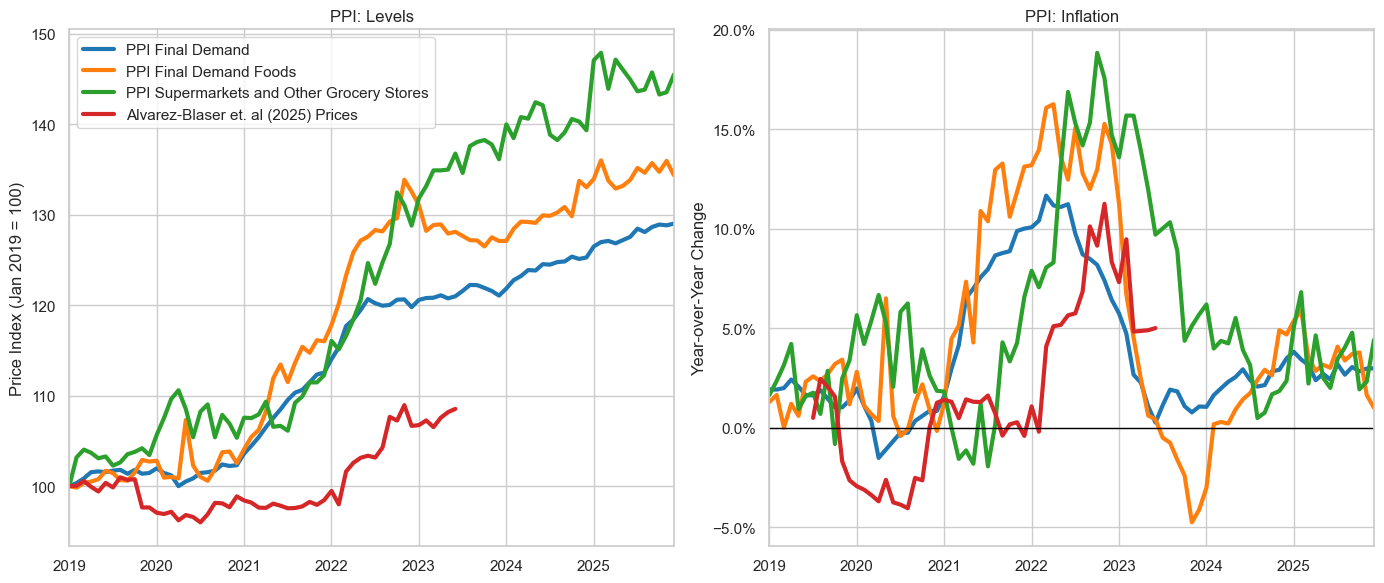

In [13]:
tab10 = plt.get_cmap('tab10').colors
series_colors = {
    'WPUFD4': tab10[0],
    'WPUFD411': tab10[1],
    'PCU445110445110': tab10[2],
    'price_ret_I_all_est': 'purple',
}

fig, axes, levels_df, yoy_df= plot_ppi_series(
    df=df,
    series = ['WPUFD4','WPUFD411','PCU445110445110','price_ret_I_all_est'],
    ppi_dict=ppi_dict,
    start_date=pd.to_datetime('2019-01-01'),
    select_series_date=select_series_date,
    legend_labels="name",   # 👈 shows codes + names
    percent_xmax=100,
    series_colors=series_colors,
    save_path=out_dir / 'ppi_food.pdf',
)

In [14]:
df.query('series_id == "markup_tot_all_est"').value.mean()

np.float64(0.6740417285326853)